# 07 - Extended Error Analysis

## Import and config

In [2]:
# 07_extended_error_analysis.ipynb
# Extended error analysis for Scania PdM project

import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    precision_recall_curve,
)
from sklearn.calibration import calibration_curve
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import PartialDependenceDisplay
from scipy import stats

import shap

sns.set(style="whitegrid")

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load test data, model and compute predictions

In [3]:
# Load tuned XGBoost model from pickle
tuned_model_filename = "xgb_pdm_finetuned.pkl"
model = joblib.load(tuned_model_filename)
threshold = 0.51

print("Loaded tuned model from:", tuned_model_filename)

# Path to engineered feature matrix
test_path = "test_vehicle_features.csv"
df_test = pd.read_csv(test_path)

print("Test shape:", df_test.shape)

VEHICLE_COL = "vehicle_id"
TARGET_COL = "in_study_repair"

# Features are all columns except vehicle id + target
feature_cols = [c for c in df_test.columns if c not in [VEHICLE_COL, TARGET_COL]]

X_test = df_test[feature_cols]
y_true = df_test[TARGET_COL].astype(int)

# Model predictions
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

# Build error-analysis frame
df_err = df_test[[VEHICLE_COL]].copy()     # keep vehicle_id for inspection
df_err = pd.concat([df_err, X_test], axis=1)
df_err["y_true"] = y_true
df_err["y_proba"] = y_proba
df_err["y_pred"] = y_pred

df_err["error_type"] = np.select(
    [
        (y_pred == 1) & (y_true == 0),   # predicted failure, actually healthy
        (y_pred == 0) & (y_true == 1),   # predicted healthy, actually failure
    ],
    ["FP", "FN"],
    default="Correct",
)

Loaded tuned model from: xgb_pdm_finetuned.pkl
Test shape: (5045, 577)


## Cluster-specific SHAP summary plots (FP vs FN)
[Geeks for Geeks: Leveraging SHAP Values for Model Insights and Enhanced Performance](https://www.geeksforgeeks.org/machine-learning/leveraging-shap-values-for-model-insights-and-enhanced-performance/ "Geeks for geeks article on SHAP")

Explainer created: <class 'shap.explainers._permutation.PermutationExplainer'>


PermutationExplainer explainer: 201it [07:07,  2.14s/it]                         
PermutationExplainer explainer: 40it [01:20,  2.37s/it]                        
/tmp/ipykernel_3104/1156456864.py:53: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


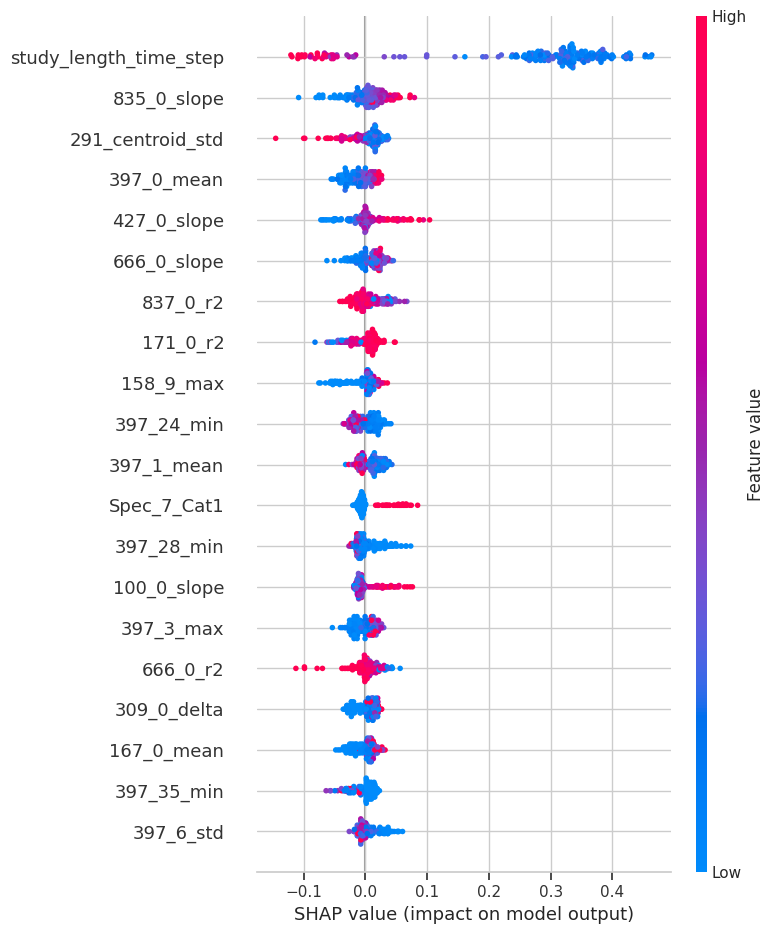

/tmp/ipykernel_3104/1156456864.py:62: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


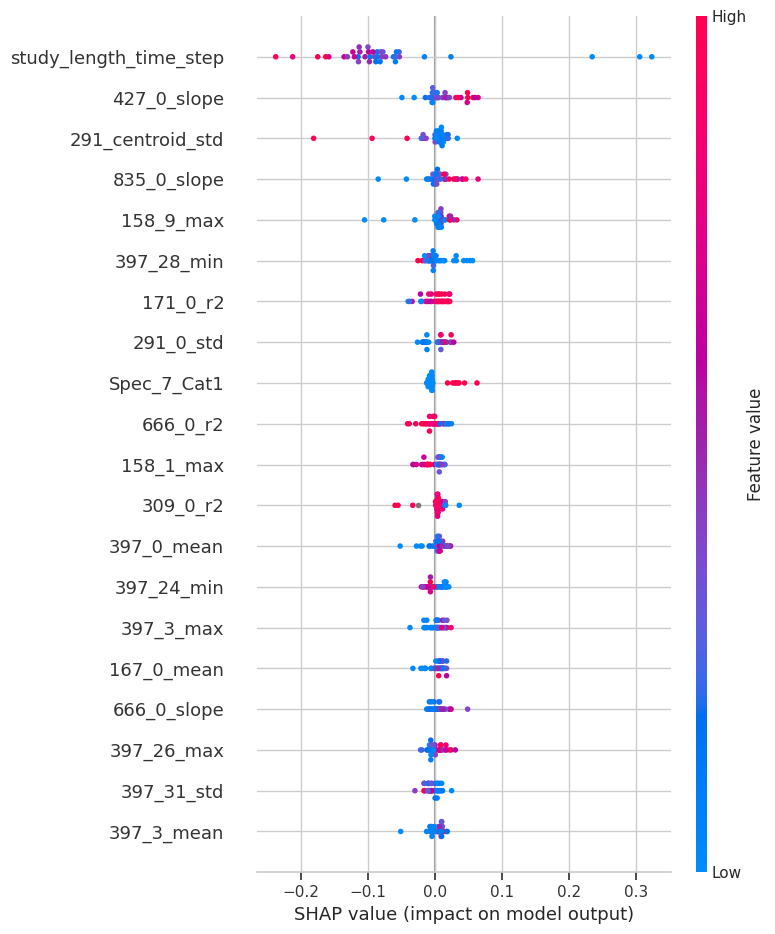

In [5]:
# Use a small background set only if you want to force probability space explanations
# Otherwise TreeExplainer can be used directly on the model.
# Background data for the explainer
X_bg = X_test[feature_cols].sample(min(500, len(X_test)), random_state=42)

# Force permutation explainer (since TreeExplainer breaks in this env)
explainer = shap.Explainer(
    model.predict_proba,
    X_bg,
    algorithm="permutation",
)

print("Explainer created:", type(explainer))

def get_shap_values_subset(mask, max_samples=200):
    """
    Compute SHAP values for a subset (FP or FN) in batch.
    Returns:
        X_sub       : DataFrame (n_samples, n_features)
        shap_vals_1 : ndarray  (n_samples, n_features) for class 1
    """
    idxs = np.where(mask)[0]
    if len(idxs) == 0:
        raise ValueError("Mask selects 0 rows – nothing to explain.")

    if len(idxs) > max_samples:
        idxs = np.random.choice(idxs, size=max_samples, replace=False)

    X_sub = X_test.iloc[idxs][feature_cols]

    # PermutationExplainer needs max_evals >= 2 * n_features + 1
    n_features = X_sub.shape[1]
    max_evals = max(2 * n_features + 1, 1200)  # ~1151 for 575 features

    # sv.values shape: (n_samples, n_features, n_outputs)
    sv = explainer(X_sub, max_evals=max_evals)

    # Take SHAP values for class 1 (failure) -> (n_samples, n_features)
    shap_vals_class1 = sv.values[..., 1]

    # Sanity check
    assert shap_vals_class1.shape[:2] == X_sub.shape

    return X_sub, shap_vals_class1

mask_fp = df_err["error_type"] == "FP"
mask_fn = df_err["error_type"] == "FN"

X_fp_shap, sv_fp_vals = get_shap_values_subset(mask_fp, max_samples=200)
X_fn_shap, sv_fn_vals = get_shap_values_subset(mask_fn, max_samples=200)

# FP
shap.summary_plot(
    sv_fp_vals,
    X_fp_shap,
    feature_names=feature_cols,
    max_display=20, # 20 features with the largest mean |SHAP| within the FP subset
    show=True,   # or False if we embed in custom plt.figure
)

# FN
shap.summary_plot(
    sv_fn_vals,
    X_fn_shap,
    feature_names=feature_cols,
    max_display=20,
    show=True,
)

In [6]:
# For FP
mean_abs_fp = np.mean(np.abs(sv_fp_vals), axis=0)  # (n_features,)
fp_importance = (
    pd.Series(mean_abs_fp, index=feature_cols)
      .sort_values(ascending=False)
)

print(fp_importance.head(20))

study_length_time_step    0.276238
835_0_slope               0.020896
291_centroid_std          0.020147
397_0_mean                0.018652
427_0_slope               0.018272
666_0_slope               0.016389
837_0_r2                  0.015823
171_0_r2                  0.015446
158_9_max                 0.015020
397_24_min                0.014999
397_1_mean                0.014818
Spec_7_Cat1               0.014454
397_28_min                0.014421
100_0_slope               0.014292
397_3_max                 0.013782
666_0_r2                  0.013775
309_0_delta               0.013563
167_0_mean                0.013281
397_35_min                0.012565
397_6_std                 0.012310
dtype: float64


/tmp/ipykernel_3104/3369013093.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


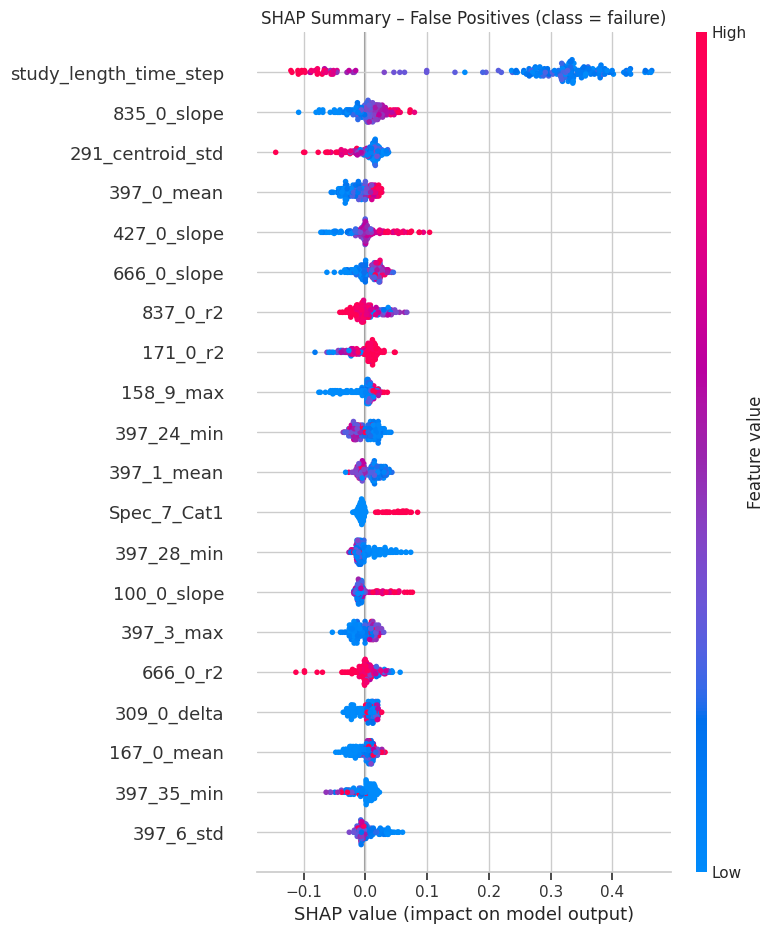

/tmp/ipykernel_3104/3369013093.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


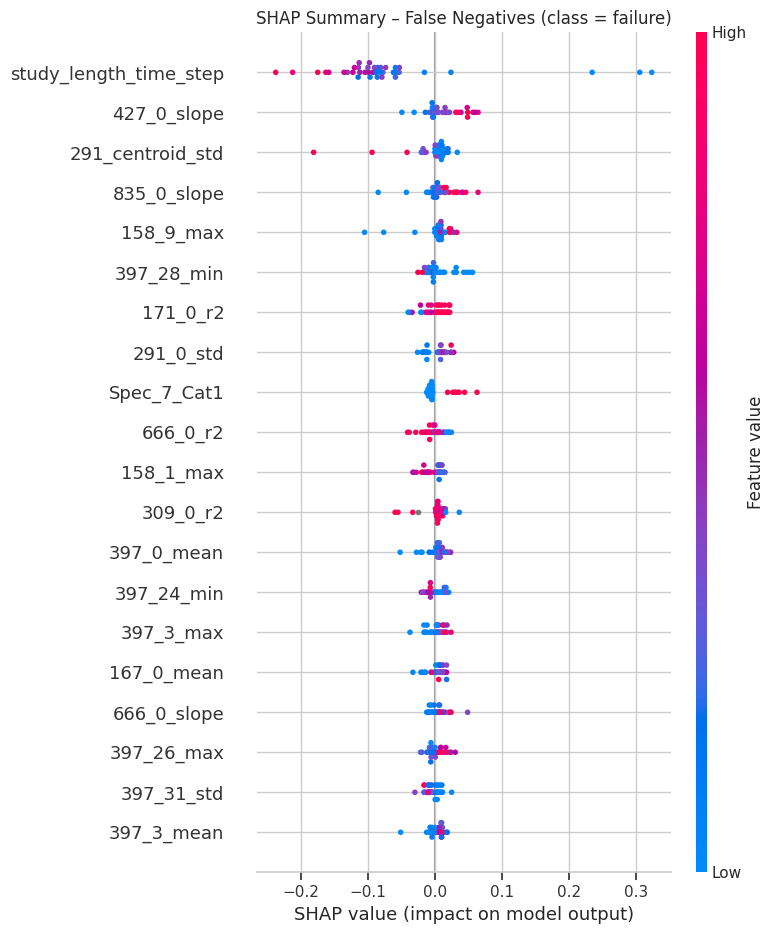

In [7]:
# 1.3 SHAP summary plots
# SHAP summary for False Positives
# FP
shap.summary_plot(
    sv_fp_vals,
    X_fp_shap,
    feature_names=feature_cols,
    max_display=20, # 20 features with the largest mean |SHAP| within the FP subset
    show=False,   # or False if we embed in custom plt.figure
)
plt.title("SHAP Summary – False Positives (class = failure)")
plt.tight_layout()
plt.show()


# FN
shap.summary_plot(
    sv_fn_vals,
    X_fn_shap,
    feature_names=feature_cols,
    max_display=20,
    show=False,
)
plt.title("SHAP Summary – False Negatives (class = failure)")
plt.tight_layout()
plt.show()

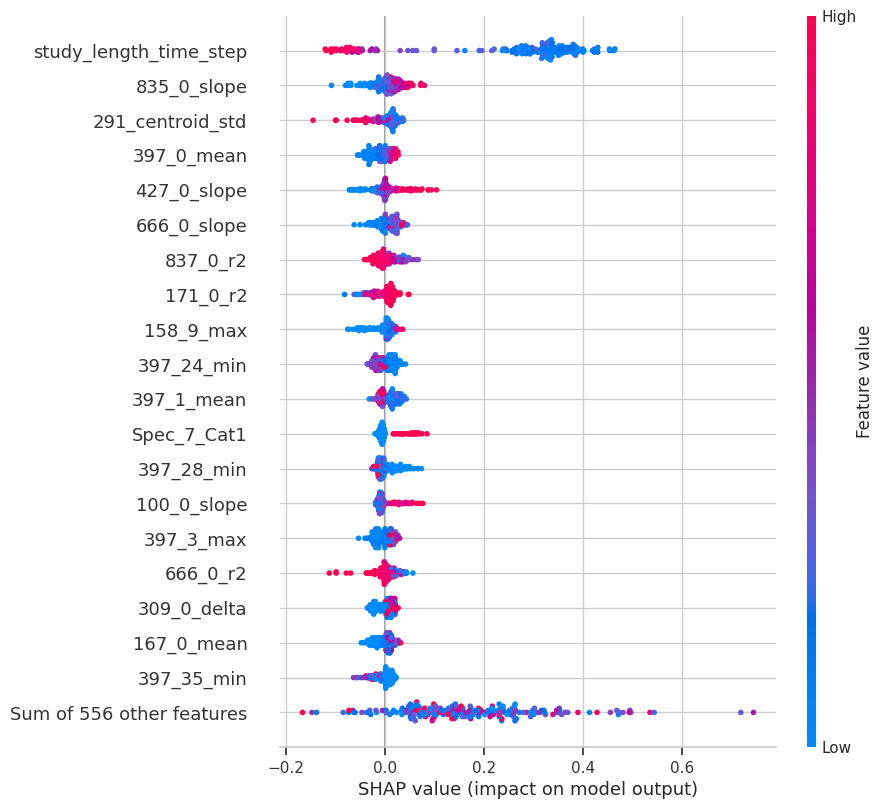

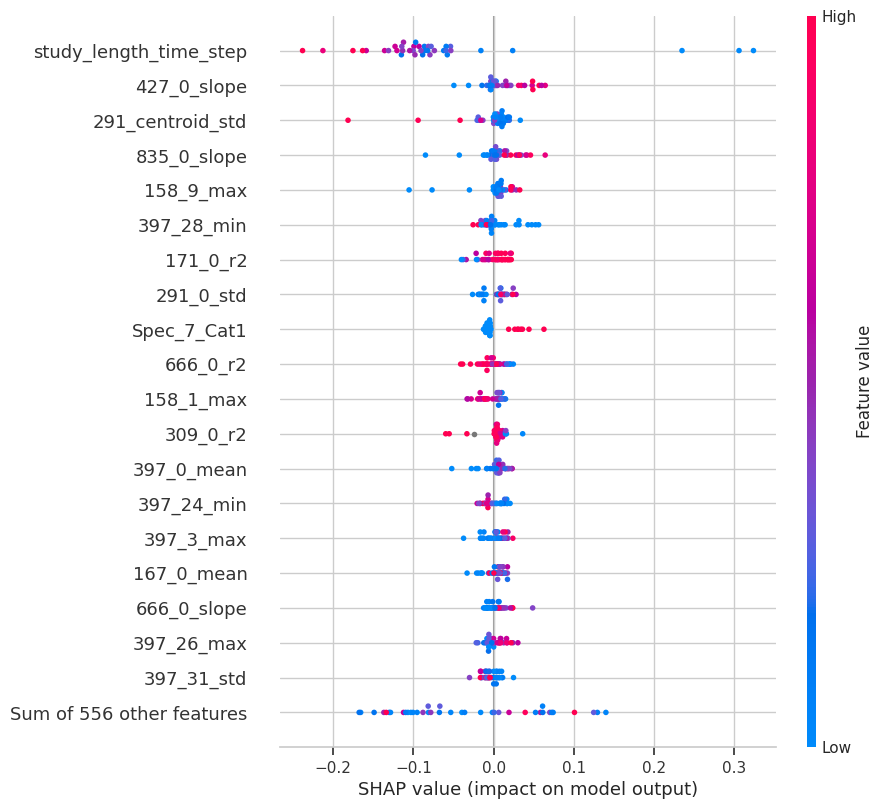

In [8]:
# sv_fp_vals: (n_samples, n_features)
# X_fp_shap:  (n_samples, n_features)

# For False Positives:
fp_expl = shap.Explanation(
    values=sv_fp_vals,
    base_values=np.zeros(sv_fp_vals.shape[0]),  # dummy base values
    data=X_fp_shap.values,
    feature_names=list(X_fp_shap.columns),
)

shap.plots.beeswarm(fp_expl, max_display=20, show=True)

# For False Negatives:
fn_expl = shap.Explanation(
    values=sv_fn_vals,
    base_values=np.zeros(sv_fn_vals.shape[0]),
    data=X_fn_shap.values,
    feature_names=list(X_fn_shap.columns),
)

shap.plots.beeswarm(fn_expl, max_display=20, show=True)


## 2. Time-series backtracking for representative FP/FN samples
> Assumes access to raw time series

In [9]:
# OPTIONAL: raw time-series backtracking
# Assumes df_raw has columns [VEHICLE_COL, "time", sensor_1, sensor_2, ...]

VEHICLE_COL = "vehicle_id"  # adjust if needed
TIME_COL = "time_step"      # or whatever your time column is called

def plot_vehicle_timeseries(vehicle_id, df_raw, sensor_cols, title_suffix=""):
    df_v = df_raw[df_raw[VEHICLE_COL] == vehicle_id].sort_values(TIME_COL)
    fig, axes = plt.subplots(len(sensor_cols), 1, figsize=(10, 3 * len(sensor_cols)), sharex=True)
    if len(sensor_cols) == 1:
        axes = [axes]
    for ax, col in zip(axes, sensor_cols):
        ax.plot(df_v[TIME_COL], df_v[col])
        ax.set_ylabel(col)
    axes[-1].set_xlabel(TIME_COL)
    plt.suptitle(f"Vehicle {vehicle_id} – raw time series {title_suffix}")
    plt.tight_layout()
    plt.show()

# Example: pick one FP and one FN and inspect a few key sensors
if VEHICLE_COL in df_err.columns:
    fp_id = df_err[df_err.error_type == "FP"][VEHICLE_COL].iloc[0]
    fn_id = df_err[df_err.error_type == "FN"][VEHICLE_COL].iloc[0]

    key_sensors = ["sensor_158", "sensor_397", "sensor_459"]  # TODO: adapt to your naming

    # plot_vehicle_timeseries(fp_id, df_raw, key_sensors, title_suffix="(False Positive)")
    # plot_vehicle_timeseries(fn_id, df_raw, key_sensors, title_suffix="(False Negative)")

## 3. Partial Dependence & ICE for key features (FP vs FN)

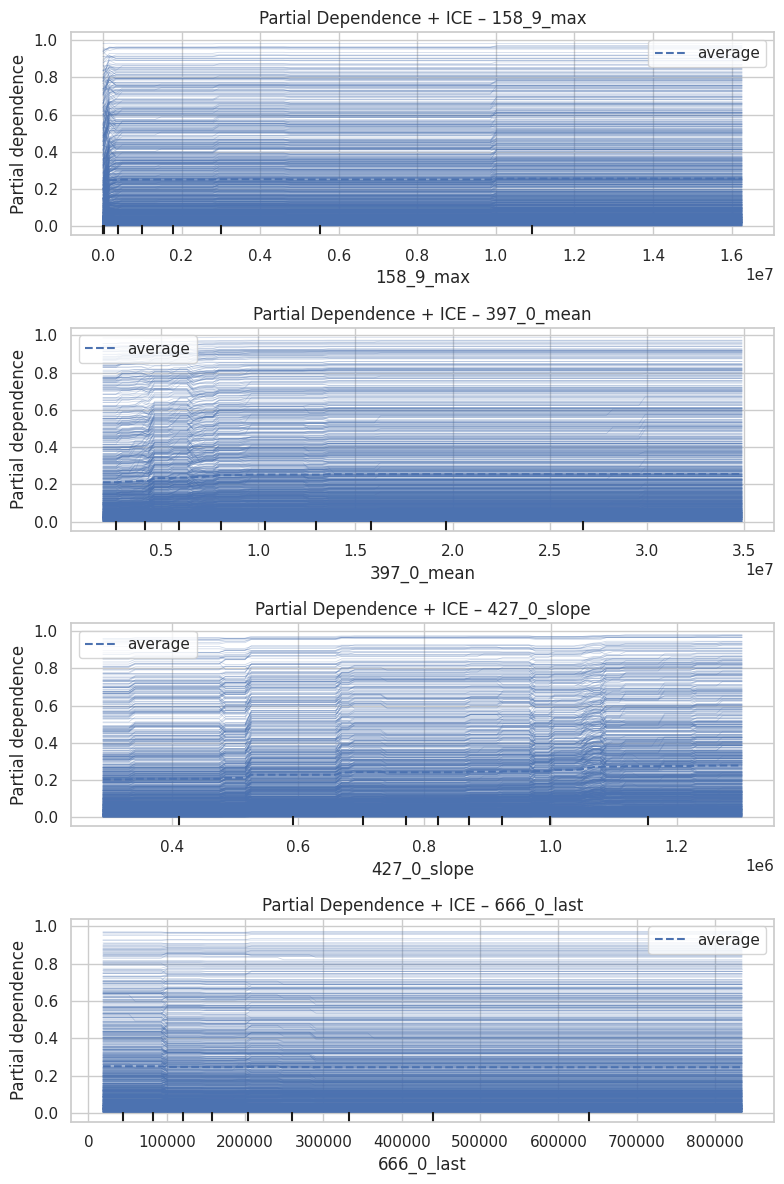

In [10]:
from sklearn.inspection import PartialDependenceDisplay

# pick a handful of important features
pdp_features = ["158_9_max", "397_0_mean", "427_0_slope", "666_0_last"]  # adapt to your top ones

# For XGBoost via scikit interface, we can call PDP directly on the model
fig, ax = plt.subplots(len(pdp_features), 1, figsize=(8, 3 * len(pdp_features)))
for i, feat in enumerate(pdp_features):
    PartialDependenceDisplay.from_estimator(
        model,
        X_test[feature_cols],
        [feature_cols.index(feat)],
        kind="both",  # PDP + ICE
        ax=ax[i],
    )
    ax[i].set_title(f"Partial Dependence + ICE – {feat}")

plt.tight_layout()
plt.show()

## 4. Mutual Information ranking: FP vs FN separability

In [12]:
X_fp_fn.isna().sum().sort_values(ascending=False).head(10)

370_0_r2       479
309_0_r2        37
837_0_r2         5
171_0_first      0
397_21_max       0
397_20_min       0
397_20_max       0
397_21_mean      0
397_21_std       0
397_21_min       0
dtype: int64

In [13]:
cols_to_keep = X_fp_fn.columns[X_fp_fn.isna().mean() < 0.5]  # e.g. < 50% missing
X_fp_fn_reduced = X_fp_fn[cols_to_keep]

In [15]:
# Binary label: 1 = FN, 0 = FP (we only compare within misclassifications)
from sklearn.impute import SimpleImputer

mask_fp_fn = df_err.error_type.isin(["FP", "FN"])
y_fp_fn = (df_err.loc[mask_fp_fn, "error_type"] == "FN").astype(int)
X_fp_fn = X_test.loc[mask_fp_fn, feature_cols]

# Median imputation
imputer = SimpleImputer(strategy="median")
X_fp_fn_imputed = imputer.fit_transform(X_fp_fn)  # ndarray (n_samples, n_features)

mi_scores = mutual_info_classif(
    X_fp_fn_imputed,
    y_fp_fn,
    random_state=42,
    discrete_features=False,
)

mi_series = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)
mi_series.head(20)

study_length_time_step    0.060516
158_3_mean                0.059527
171_0_delta               0.058935
427_0_delta               0.057986
171_0_mean                0.057127
427_0_mean                0.055371
158_total_std             0.052425
835_0_delta               0.052250
427_0_std                 0.051791
167_total_max             0.051637
171_0_last                0.051318
158_5_mean                0.050791
158_4_std                 0.050011
459_15_max                0.049895
171_0_std                 0.049185
158_4_mean                0.048982
397_total_std             0.048799
835_0_std                 0.048304
272_total_std             0.048239
167_5_max                 0.048051
dtype: float64

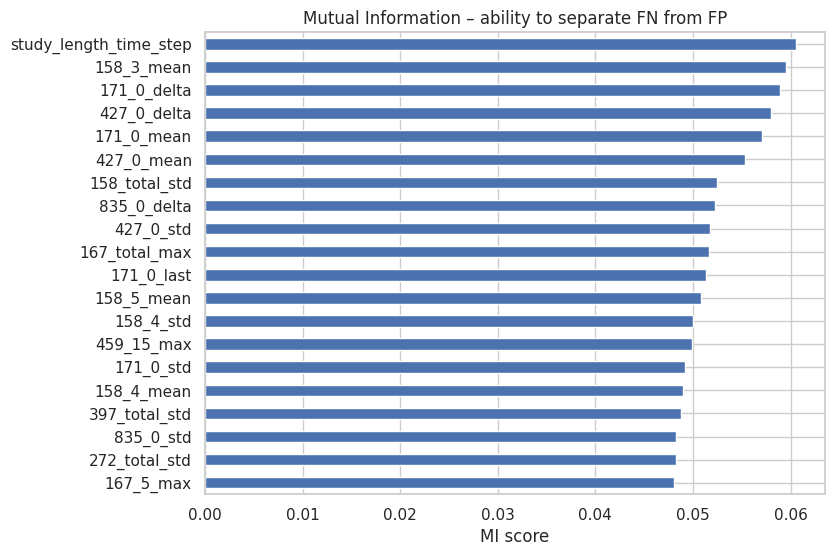

In [16]:
plt.figure(figsize=(8, 6))
mi_series.head(20).plot.barh()
plt.gca().invert_yaxis()
plt.title("Mutual Information – ability to separate FN from FP")
plt.xlabel("MI score")
plt.show()

## 5. Simple ablation study on feature groups

Here we retrain small models with subsets of features to see how FP/FN rates change.

In [17]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Helper to evaluate FPR and FNR on test set
def evaluate_fp_fn_rates(model, X, y_true, threshold=0.51):
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fpr = fp / (fp + tn + 1e-9)
    fnr = fn / (fn + tp + 1e-9)
    return fpr, fnr

# Example feature groups
group_all = feature_cols
group_no_slope = [f for f in feature_cols if "slope" not in f]
group_only_slope = [f for f in feature_cols if "slope" in f]

X_train_ab, X_val_ab, y_train_ab, y_val_ab = train_test_split(
    X_test[group_all], df_err["y_true"], test_size=0.3, random_state=42, stratify=df_err["y_true"]
)

def train_and_eval(subset_features, name):
    model_ab = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        eval_metric="logloss",
    )
    model_ab.fit(X_train_ab[subset_features], y_train_ab)
    fpr, fnr = evaluate_fp_fn_rates(model_ab, X_val_ab[subset_features], y_val_ab)
    print(f"{name}: FPR={fpr:.4f}, FNR={fnr:.4f}")

train_and_eval(group_all, "All features")
train_and_eval(group_no_slope, "Without slope features")
train_and_eval(group_only_slope, "Only slope features")

All features: FPR=0.0000, FNR=1.0000
Without slope features: FPR=0.0000, FNR=1.0000
Only slope features: FPR=0.0000, FNR=1.0000


## 6. Reliability diagrams (calibration)

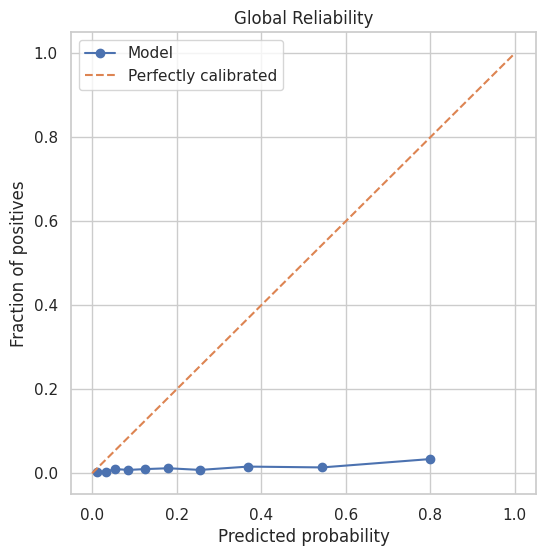

Brier score: 0.1231


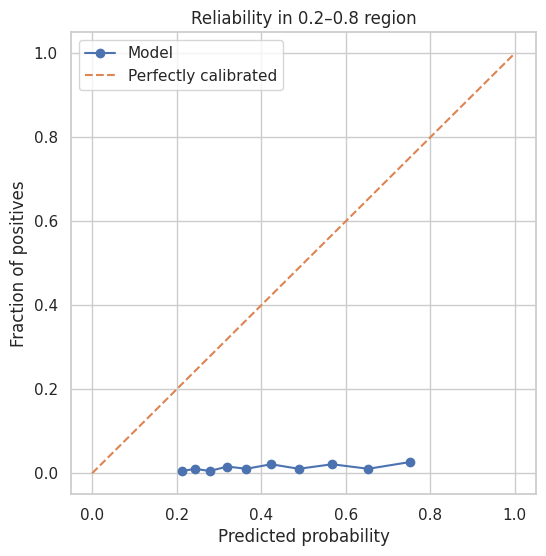

Brier score: 0.2155


In [18]:
def plot_reliability(y_true, y_proba, n_bins=10, title="Reliability Diagram"):
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=n_bins, strategy="quantile")

    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker="o", label="Model")
    plt.plot([0, 1], [0, 1], "--", label="Perfectly calibrated")
    plt.xlabel("Predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    bs = brier_score_loss(y_true, y_proba)
    print(f"Brier score: {bs:.4f}")

plot_reliability(df_err["y_true"], df_err["y_proba"], title="Global Reliability")

# Optional: reliability just for FP/FN regions (e.g. samples with 0.2 < p < 0.8)
mask_mid = (df_err["y_proba"] > 0.2) & (df_err["y_proba"] < 0.8)
plot_reliability(df_err.loc[mask_mid, "y_true"], df_err.loc[mask_mid, "y_proba"],
                 title="Reliability in 0.2–0.8 region")

## 7. Hypothesis tests: FP vs FN per feature

We’ll apply a nonparametric Mann–Whitney U-test for the top N features.

In [19]:
top_n = 20  # reuse earlier list if you like
top_features_for_tests = mi_series.head(20).index

results = []
for f in top_features_for_tests:
    fp_vals = df_err[df_err.error_type == "FP"][f]
    fn_vals = df_err[df_err.error_type == "FN"][f]
    stat, p = stats.mannwhitneyu(fp_vals, fn_vals, alternative="two-sided")
    results.append((f, stat, p))

df_tests = pd.DataFrame(results, columns=["feature", "u_stat", "p_value"])
df_tests["p_value_adj"] = df_tests["p_value"] * len(df_tests)  # simple Bonferroni

df_tests.sort_values("p_value").head(20)

,feature,u_stat,p_value,p_value_adj
5,427_0_mean,3372.0,8.608850e-17,1.721770e-15
3,427_0_delta,3415.0,1.094898e-16,2.189796e-15
4,171_0_mean,3415.0,1.094898e-16,2.189796e-15
2,171_0_delta,3435.0,1.224125e-16,2.448251e-15
1,158_3_mean,3481.0,1.581176e-16,3.162352e-15
8,427_0_std,3506.0,1.816447e-16,3.632893e-15
10,171_0_last,3542.0,2.216993e-16,4.433987e-15
14,171_0_std,3559.0,2.435266e-16,4.870533e-15
19,167_5_max,3650.0,4.017194e-16,8.034388e-15
9,167_total_max,3767.0,7.605210e-16,1.521042e-14


## 8. Archetype tables (error “personas”)

In [33]:
# Example: summarize archetypes by error_type and maybe by FP cluster if you include it
summary_cols = [
    "158_9_max",
    "397_0_max",
    "427_0_slope",
    "666_0_last",
    "study_length_time_step",
]

df_archetypes = df_err.groupby("error_type")[summary_cols].mean().T
df_archetypes

error_type,Correct,FN,FP
158_9_max,3.632515e+06,7.080134e+06,3.343265e+06
397_0_max,2.581157e+07,2.403100e+07,1.434138e+07
427_0_slope,8.002034e+05,1.016754e+06,8.566502e+05
666_0_last,2.964073e+05,4.231954e+05,2.321912e+05
study_length_time_step,2.067861e+02,2.089846e+02,1.150613e+02


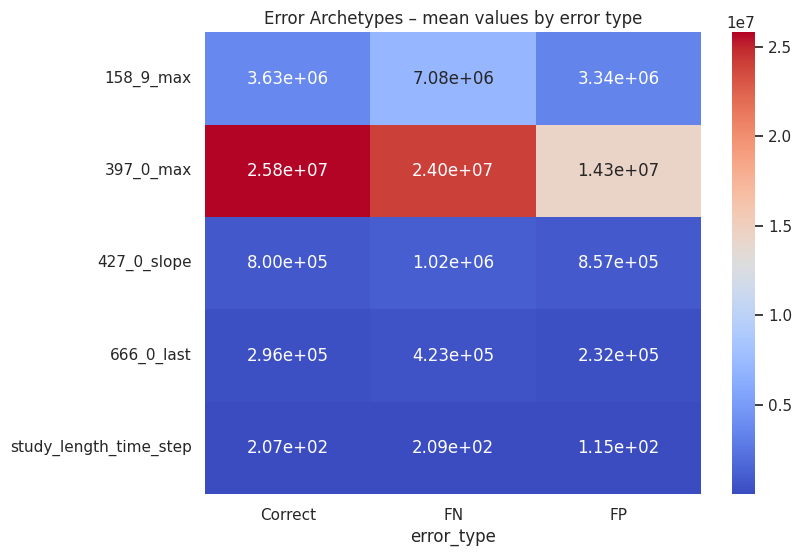

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_archetypes, annot=True, fmt=".2e", cmap="coolwarm")
plt.title("Error Archetypes – mean values by error type")
plt.show()

If cluster labels for FP are available:

In [35]:
if "cluster" in df_err.columns:
    df_fp_cluster_summary = df_err[df_err.error_type == "FP"].groupby("cluster")[summary_cols].mean().T
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_fp_cluster_summary, annot=True, fmt=".2e", cmap="coolwarm")
    plt.title("False Positive Archetypes by Cluster")
    plt.show()

## 9. Simple diagram for documentation (optional)

A quick, code-generated diagram describing the flow from raw sensors → features → decisions → errors:

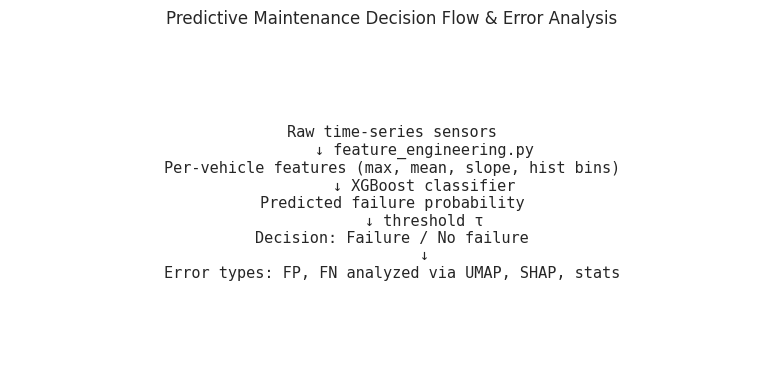

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis("off")

text = (
    "Raw time-series sensors\n"
    "       ↓ feature_engineering.py\n"
    "Per-vehicle features (max, mean, slope, hist bins)\n"
    "       ↓ XGBoost classifier\n"
    "Predicted failure probability\n"
    "       ↓ threshold τ\n"
    "Decision: Failure / No failure\n"
    "       ↓\n"
    "Error types: FP, FN analyzed via UMAP, SHAP, stats"
)

ax.text(0.5, 0.5, text, ha="center", va="center", fontsize=11, family="monospace")
plt.title("Predictive Maintenance Decision Flow & Error Analysis")
plt.tight_layout()
plt.show()